## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()

mirna_tumor (506, 1883)
mirna_normal (46, 1883)
gene_tumor (515, 20486)
gene_normal (59, 20486)


## Univariate feature selection via FDR

In [150]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

ValueError: could not convert string to float: TCGA-91-6849

## Loading TargetScan database for predicted miRNA-targets interactions

In [3]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(tgca_luad.mirna_list) & targetScan_df['Gene Symbol'].isin(tgca_luad.gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Loading miRanda database for predicted miRNA-targets interactions

In [4]:
miRanda_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/miRanda_hg19_predictions_S_C_aug2010.txt'), delimiter='\t')
miRanda_df = miRanda_df[['mirna_name',  'gene_symbol']]

miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.lower()
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("*", "")
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("-3p.*|-5p.*", "")
print miRanda_df.shape

miRanda_df.columns = ["MiRBase ID", "Gene Symbol"]
miRanda_df = miRanda_df[miRanda_df['MiRBase ID'].isin(tgca_luad.mirna_list) & miRanda_df['Gene Symbol'].isin(tgca_luad.gene_symbols)].dropna().drop_duplicates()
print miRanda_df.shape
putative_assocs = pandas.concat([targetScan_df, miRanda_df]).dropna().drop_duplicates()
print putative_assocs.shape

(1097064, 2)


(544648, 2)


(640757, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [97]:
%%time
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(miRNAs=tgca_luad.mirna_list, targets=tgca_luad.gene_symbols)

res = network.fit(tag="normal-StgI", dys_threshold=0.6,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 20
n_B 275


ValueError: cannot compute fingerprint of empty list

Traceback
---------
  File "/opt/anaconda/lib/python2.7/site-packages/dask/async.py", line 268, in execute_task
    result = _execute_task(task, data)
  File "/opt/anaconda/lib/python2.7/site-packages/dask/async.py", line 249, in _execute_task
    return func(*args2)
  File "/opt/anaconda/lib/python2.7/site-packages/dask/dataframe/core.py", line 3013, in apply_and_enforce
    df = func(*args, **kwargs)


In [51]:
%%time
network.fit(tag="StgI-StgII", dys_threshold=0.5,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 275
n_B 120


CPU times: user 7min 25s, sys: 76 ms, total: 7min 25s
Wall time: 7min 25s


1364

In [21]:
network.fit(tag="StgII-StgIII", dys_threshold=0.5,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 120
n_B 84


3523

In [22]:
network.fit(tag="StgIII-StgIV", dys_threshold=0.8,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 84
n_B 24


5001

In [96]:
network.build_miRNA_features()

miRNAs_in_MTDN 249
normal_stgI_genes 7270
stgI_StgII_genes 0
stgII_StgIII_genes 0
stgIII_StgIV_genes 0


In [24]:
from sklearn.cluster import AgglomerativeClustering

mirna_cluster = AgglomerativeClustering(n_clusters=20, affinity='l1', linkage='complete').fit(
    network.miRNA_target_assn_matrix)

print np.bincount(mirna_cluster.labels_)

[244   2   2   2   2   1   2   1   1   1   3   1   1   1   1   1   1   1
   1   1]


In [21]:
network.miRNA_target_assn_matrix.sum(axis=1).sort_values()

hsa-mir-219a-2    0.000362
hsa-mir-652       0.000362
hsa-mir-126       0.000362
hsa-mir-409       0.000362
hsa-mir-188       0.000362
hsa-mir-187       0.000362
hsa-mir-551b      0.000362
hsa-mir-378f      0.000362
hsa-mir-487b      0.000362
hsa-mir-210       0.000723
hsa-mir-490       0.000723
hsa-mir-23c       0.000723
hsa-mir-1197      0.000723
hsa-let-7e        0.000723
hsa-mir-191       0.000723
hsa-mir-708       0.001085
hsa-mir-146a      0.001085
hsa-mir-4644      0.001085
hsa-mir-383       0.001085
hsa-mir-6807      0.001085
hsa-mir-378c      0.001085
hsa-mir-151a      0.001085
hsa-mir-4676      0.001447
hsa-mir-155       0.001447
hsa-mir-185       0.001447
hsa-mir-99b       0.001447
hsa-mir-1298      0.001447
hsa-mir-6884      0.001447
hsa-mir-99a       0.001447
hsa-mir-133b      0.001808
                    ...   
hsa-mir-93        0.041514
hsa-mir-92b       0.042490
hsa-mir-493       0.043213
hsa-mir-15b       0.044212
hsa-mir-106b      0.045294
hsa-mir-488       0.046049
h

1881


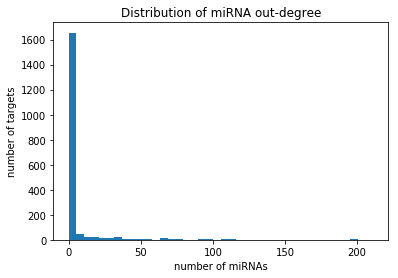

In [25]:
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite'] == 0)
targets_nodes = set(network.B) - miRNAs_nodes

miRNA_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
print len(miRNA_nodes_degrees)

plt.figure()
plt.hist(miRNA_nodes_degrees.values(), bins=40)
plt.title('Distribution of miRNA out-degree')
plt.ylabel('number of targets')
plt.xlabel('number of miRNAs')
plt.show()

In [26]:
miRNA_nodes_degrees.values()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 36,
 482,
 330,
 0,
 33,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 111,
 206,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 266,
 251,
 0,
 0,
 0,
 231,
 214,
 0,
 0,
 71,
 0,
 0,
 355,
 0,
 0,
 0,
 0,
 0,
 0,
 43,
 0,
 231,
 202,
 132,
 0,
 0,
 0,
 0,
 0,
 0,
 190,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 57,
 0,
 0,
 0,
 0,
 0,
 0,
 120,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 466,
 175,
 81,
 80,
 0,
 0,
 141,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 20,
 0,
 0,
 0,
 461,
 297,
 166,
 0,
 0,
 0,
 113,
 325,
 0,
 0,
 311,
 346,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 158,
 0,
 192,
 81,
 297,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

20484


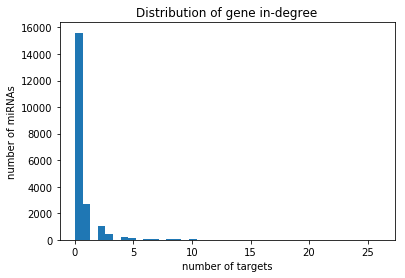

In [26]:
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]
print len(targets_nodes_degrees)

plt.figure()
plt.hist(targets_nodes_degrees.values(), bins=40)
plt.title('Distribution of gene in-degree')
plt.ylabel('number of miRNAs')
plt.xlabel('number of targets')
plt.show()

[260, 7, 1, 1, 1]


[257, 5, 3, 2, 1, 1, 1]


[252, 5, 3, 2, 2, 2, 1, 1, 1, 1]


[249, 5, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1]


[248, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[246, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[244, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


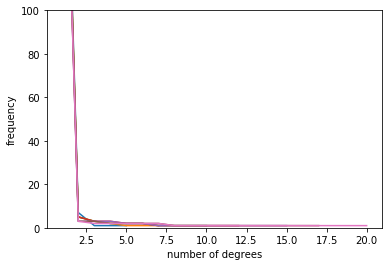

In [33]:
n_clusters = [5, 7, 10, 12, 15, 17, 20]

plt.figure()
for n_cluster in n_clusters:
    bin_count = network.run_miRNA_clustering(n_cluster=n_cluster, linkage='complete')
    print sorted(bin_count, reverse=True)
    plt.plot(range(1, len(bin_count)+1), sorted(bin_count, reverse=True))
plt.ylabel('frequency')
plt.xlabel('number of degrees')
plt.ylim(0, 100)
plt.show()

## TarBase: Validated miRNA-target interactions

In [28]:
TarBase_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TarBase_Experiment_Valid_miRNA-Targets.csv'), delimiter='\t')
TarBase_df = TarBase_df[TarBase_df['species'] == 'Homo sapiens']
TarBase_df = TarBase_df[TarBase_df['tissue'].isin(['Lung Cancerous Tissues', 'Lung'])]
TarBase_df = TarBase_df[TarBase_df['category'] == 'Cancer/Malignant']
TarBase_df['mirna'] = TarBase_df['mirna'].str.lower()
TarBase_df['mirna'] = TarBase_df['mirna'].str.replace("-3p.*|-5p.*", "")
TarBase_df.drop_duplicates(inplace=True)

TarBase_df = TarBase_df[['geneName', 'mirna']]
# TarBase_df

In [29]:
for row in TarBase_df.iterrows():
    if network.B.get_edge_data(row[1]['mirna'], row[1]['geneName']):
        print row[1]['mirna'], row[1]['geneName'], network.B.get_edge_data(row[1]['mirna'], row[1]['geneName'])

### Prepare samples for Classification task

In [30]:
from sklearn.model_selection import train_test_split

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['Stage I', 'Stage II'], 
                              label_mapping={'normal': -1, 'Stage I': -1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

X_multi, y_multi = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                                          pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                                          label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)

print "X", X.shape
print "y", y.shape

print y.value_counts()
print y_multi.value_counts()

X (398, 1881)
y (398,)
-1    277
 1    121
Name: pathologic_stage, dtype: int64
1    277
2    121
3     84
0     46
4     24
Name: pathologic_stage, dtype: int64


## Create Classifiers

In [31]:
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)


X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Group Lasso L2
# group_l2_param = param.copy()
# group_l2_param['loss'] = 'weighted-logistic'
# group_l2_param['regul'] = 'group-lasso-l2'
# group_l2 = SPAMSClassifier()
# group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# Sparse Group Lasso
sparse_group_l2_param = param.copy()
sparse_group_l2_param['loss'] = 'logistic'
sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2_param['lambda1'] = 0.2
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(), params=sparse_group_l2_param)

# Multi Logistic
multi_task_l1l2_param = param.copy()
multi_task_l1l2_param['loss'] = 'multi-logistic'
multi_task_l1l2_param['regul'] = 'l1l2'
multi_task_l1l2 = SPAMSClassifier()
multi_task_l1l2.fit(X_multi_train, Y_multi_train, groups=None, params=multi_task_l1l2_param)

FISTA Flat: {'loss': 'weighted-logistic', 'regul': 'l1', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}
FISTA Flat: {'loss': 'weighted-logistic', 'regul': 'elastic-net', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}


FISTA Flat: {'loss': 'logistic', 'regul': 'sparse-group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.2, 'lambda2': 0.5, 'lambda3': 0.5}


/opt/anaconda/lib/python2.7/site-packages/spams.py:1112: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if groups == None:


FISTA Flat: {'loss': 'multi-logistic', 'regul': 'l1l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}


array([[  8.44367337e-01],
       [  4.33749211e-02],
       [  9.48630271e-01],
       [  1.00100000e+03]])

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [34]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors
# 
# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   network.miRNA_clusters_int
                                   # weights=[2*1./len(g) for g in network.miRNA_groups_int]
                                   )
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=4.5, l2=0.0, gl=2.5, A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

Non-zero: 583


## Parameter selection

In [35]:
from sklearn.model_selection import StratifiedKFold

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                              label_mapping={'normal': 0, 'Stage I': 0, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})
X = X.values
y = y.values

parameters = {'alpha': [0, 0.15, 0.35, 0.5, 0.65, 0.85, 1.0],
              'lambda': [0, 0.5, 0.75, 1.0, 2., 3., 4.]}

# parameters = {'l1': [0.05, 2, 3, 5, 10, 20, 30],
#               'gl': [0.05, 2, 3, 5, 10, 20, 30]}

kf = StratifiedKFold(n_splits=5, shuffle=True)

l1_scores = []
for alpha in parameters['alpha']:
    clf = estimators.LogisticRegressionL1L2GL(l1=5*alpha, l2=0.0, gl=10.0*(1-alpha), A=A,
                                               class_weight='auto',
                                               algorithm=algorithms.proximal.FISTA(),
                                               algorithm_params=dict(max_iter=1000),
                                               mean=False)

    cv_mean = []
    for train, test in kf.split(X, y):
        clf.fit(X[train], y[train], beta=start_vectors.ZerosStartVector().get_vector(X.shape[1]))
        score = metrics.f1_score(y_true=y[test], y_pred=clf.predict(X[test]))
        cv_mean.append(score)
        
    l1_scores.append(np.mean(cv_mean))

gl_scores = []
for lambd in parameters['lambda']:
    clf = estimators.LogisticRegressionL1L2GL(l1=5*lambd, l2=0.0, gl=10*lambd, A=A,
                                               class_weight='auto',
                                               algorithm=algorithms.proximal.FISTA(),
                                               algorithm_params=dict(max_iter=1000),
                                               mean=False)

    cv_mean = []
    for train, test in kf.split(X, y):
        clf.fit(X[train], y[train], beta=start_vectors.ZerosStartVector().get_vector(X.shape[1]))
        score = metrics.f1_score(y_true=y[test], y_pred=clf.predict(X[test]))
        cv_mean.append(score)

    gl_scores.append(np.mean(cv_mean))

NameError: name 'metrics' is not defined

In [36]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(parameters['alpha'], l1_scores, 'o-')

plt.xlabel('alpha')
plt.ylabel('f1-score, averaged on 5-fold cross validation')
plt.title('')
# plt.ylim(0, 1)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

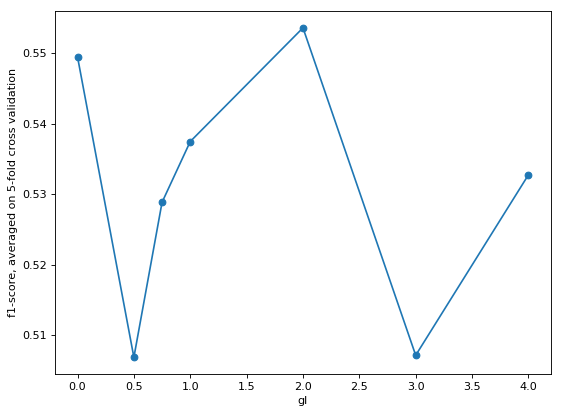

In [210]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(parameters['lambda'], gl_scores, 'o-')

plt.xlabel('gl')
plt.ylabel('f1-score, averaged on 5-fold cross validation')
plt.title('')
# plt.ylim(0,1)
plt.show()


## Classification Report

In [35]:
from sklearn import metrics

for model, name in [
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (multi_task_l1l2, 'multi-task l1l2'),
                    # (group_l2, 'group_small'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    ]:
    print '\n', name
    if model is logistic_L1L2GL:
        predicted = logistic_L1L2GL.predict(X_train)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_train, predicted)
        predicted = logistic_L1L2GL.predict(X_test)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_test, predicted)
    elif model.params['loss'] == 'multi-logistic':
        print metrics.classification_report(Y_multi_train, model.predict(X_multi_train))
        print metrics.classification_report(Y_multi_test, model.predict(X_multi_test))
    else:
        print metrics.classification_report(Y_train, model.predict(X_train))
        print metrics.classification_report(Y_test, model.predict(X_test))


Logistic L1L2GL
             precision    recall  f1-score   support

       -1.0       0.83      0.67      0.74       221
        1.0       0.48      0.69      0.57        97

avg / total       0.72      0.68      0.69       318

             precision    recall  f1-score   support

         -1       0.80      0.62      0.70        56
          1       0.42      0.62      0.50        24

avg / total       0.68      0.62      0.64        80


multi-task l1l2
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        37
        1.0       0.64      0.93      0.76       221
        2.0       0.64      0.29      0.40        97
        3.0       0.66      0.28      0.40        67
        4.0       0.88      0.37      0.52        19

avg / total       0.68      0.67      0.63       441

             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       0.57      0.73      0.64        56
  

## Cross validation metric

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                              label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})
X = X.values
y = y.values
# clf = svm.SVC(kernel='linear', C=1)

# scores = cross_val_score(logistic_L1L2GL, X, y, cv=5)
loo = LeaveOneOut()
f1_loc_scores = []
for train_index, test_index in loo.split(X, y):
    logistic_L1L2GL.fit(X[train_index], y[train_index])
    score = metrics.accuracy_score(y_true=y[test_index], y_pred=logistic_L1L2GL.predict(X[test_index]))
    f1_loc_scores.append(score)
print f1_loc_scores

KeyboardInterrupt: 


Logistic L1L2GL
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00        37
        1.0       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00       441

             precision    recall  f1-score   support

         -1       0.64      1.00      0.78         9
          1       1.00      0.95      0.97       102

avg / total       0.97      0.95      0.96       111


multi-task l1l2
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99        37
        1.0       0.68      0.76      0.72       221
        2.0       0.66      0.57      0.62       183

avg / total       0.70      0.70      0.70       441

             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.62      0.66      0.64        56
          2       0.55      0.50      0.52        46

avg / total       0.61      0.61      0.61       111



## Loading HMDD database for experimentally validated NSCLC miRNA

In [36]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

dbDEMC_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/dbDEMC.txt'), delimiter='\t')
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Type'] == 'lung cancer']
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Subtype'] == 'lung adenocarcinoma']
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.lower()
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("*", "")
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("-3p.*|-5p.*", "")
dbDEMC_luad_miRNAs = dbDEMC_df['miRNA ID'].unique()
print 'dbDEMC_luad_miRNAs', len(dbDEMC_df['miRNA ID'].unique())

validating_miRNAs = dbDEMC_luad_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,)


dbDEMC_luad_miRNAs 545


## Compare models by recall rate

In [40]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names

models = []
for model, name in [
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (multi_task_l1l2, 'multi-task l1l2'),
                    # (group_l2, 'group_small'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    ]:
    if model is logistic_L1L2GL:
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:275], tgca_luad.mirna_list),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:275], tgca_luad.mirna_list),
                                  validated_miRNAs=validating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

,method,no_selected,recall_rate,precision_rate
2,l1_lasso,275,0.370642,0.734545
3,elastic_net,275,0.370642,0.734545
1,multi-task l1l2,256,0.354128,0.753906
0,Logistic L1L2GL,583,0.341284,0.676364


## Check each candidate miRNA's if validated

In [38]:
candidate_miRNAs = multi_task_l1l2.get_selected_miRNAs(tgca_luad.mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
# candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated
50,hsa-mir-148a,-0.000126,True
180,hsa-mir-451a,-0.000102,True
69,hsa-mir-182,-0.000089,True
160,hsa-mir-372,0.000086,False
27,hsa-mir-126,-0.000084,True
225,hsa-mir-582,0.000080,True
131,hsa-mir-30d,-0.000078,True
115,hsa-mir-25,-0.000078,True
92,hsa-mir-200a,-0.000078,True
44,hsa-mir-142,0.000076,True


In [48]:
candidate_miRNAs = pandas.DataFrame([(tgca_luad.mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row : network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
91,hsa-mir-142,-0.000126,True,[]
45,hsa-mir-126,0.000121,True,[]
160,hsa-mir-205,-0.000108,True,[]
570,hsa-mir-92a-1,-0.000102,False,[]
488,hsa-mir-582,0.000099,True,[]
342,hsa-mir-451a,-0.000099,True,[]
155,hsa-mir-200c,0.000082,True,[]
571,hsa-mir-92a-2,-0.000081,False,[]
72,hsa-mir-1307,0.000079,True,[]
102,hsa-mir-150,0.000073,True,[]
